# Training a Quantum Model for NLP

Here we shall train a ``lambeq`` model to solve the relative pronoun classification task presented in [Lea2021](https://arxiv.org/pdf/2102.12846). The goal is to predict whether a noun phrase contains a subject-based or an object-based relative clause. The entries of this dataset are extracted from the `RelPron` dataset [Rea2016](https://direct.mit.edu/coli/article/42/4/661/1555/RELPRON-A-Relative-Clause-Evaluation-Data-Set-for).

We will use an `IQPAnsatz` to convert `string diagrams` into `quantum circuits`.


## What is Combinatory Categorial Grammar? 🤔
The entire process involves converting a given sentence into a quantum circuit. This is done by first converting the sentence into something called "CCG", which stands for `Combinatory Categorial Grammar`.

CCG is a way to understand how sentences are put together in a language. Think of it like a set of rules that tells us how words can combine to form meaningful sentences. Imagine you have a box of LEGO pieces (words) and a set of instructions (rules). CCG is like those instructions, helping you figure out how to snap the pieces together to build something meaningful (a sentence).

1. Categories: Every word belongs to a category. For example, nouns (like “cat”), verbs (like “run”), and adjectives (like “happy”).
2. Functions: Some words act like functions in math. They take other words (or groups of words) as input and produce a new phrase or sentence. For example, a verb like “eats” can take a noun like “apple” to form “eats apple.”
3. Combining Rules: There are specific rules for how these words and functions can combine. For example, a verb might need a noun to its right to form a complete phrase.
4. Lexicon: This is like a dictionary that tells us which category each word belongs to and how it can combine with other words.

Now that we have a basic idea of how we are going to approach things, let's get to coding!

In [1]:
import os
import warnings
import torch

os.environ['TOKENIZERS_PARALLELISM'] = 'true'
warnings.filterwarnings('ignore')

We disable warnings to filter out issues with the `tqdm` package used in jupyter notebooks.
Furthermore, we have to specify whether we want to use parallel computation for the tokenizer used by the `BobcatParser`.
None of the above impairs the performance of the code.

## Preparation

We start with importing NumPy and specifying some training hyperparameters.

In [2]:
import numpy as np

LEARNING_RATE=0.05
BATCH_SIZE = 10
EPOCHS = 100
SEED = 2

### Input data

Let's read the data and print some example sentences.

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../datasets/rp_train_data.txt')
val_labels, val_data = read_data('../datasets/rp_test_data.txt')

### Object-relative clause examples
These examples are the ones which have a object-based relative clause.
For example, for the sentences-
```
organization that church establishorganization that team join
organization that company sell
```
... we can see that the relative clauses "that church establish", "that team join" and "that company sell" are object-relative. Meaning that these clauses describe the "organization" as a function of the objects i.e "church", "team" and "company"

In [4]:
train_data[:5]

['organization that church establish .',
 'organization that team join .',
 'organization that company sell .',
 'organization that soldier serve .',
 'organization that sailor join .']

Targets are represented as 2-dimensional arrays:

In [5]:
train_labels[:5]

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]

In [6]:
train_data[-5:]

['phenomenon that require fuel .',
 'vehicle that enter port .',
 'vehicle that transport horse .',
 'vehicle that haul material .',
 'activity that build school .']

### Subject-relative clause examples
These examples are the ones which have a subject-based relative clause.
For example, for the sentences-
```
phenomenon that require fuelvehicle that enter port
vehicle that transport horse
```
... we can see that the relative clauses "phenomenon that require fuel","vehicle that enter port" and "vehicle that transport horse" are subject-relative. These clauses focus on the subjects "phenomenon" and "vehicle" and describe what they do, instead of them being a result of something else.

In [7]:
train_labels[-5:]

[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]

## Bobcat Parser 😸
BobcatParser is lambeq's latest parser and uses a transformer backend (BERT specifically) in order to parse a given sentence into Combinatory Categorial Grammar (which can be subsequently used to formulate quantum circuits).
In simple words, the BobcatParser does the following - 
1. Parsing Sentences: Imagine you have a sentence like “The cat sits on the mat.” The BobcatParser helps break down this sentence into its parts (like “The cat,” “sits,” and “on the mat”) and understand how these parts fit together.
2. 
Creating Diagrams: After breaking down the sentence, the BobcatParser can create a visual diagram that shows the structure of the sentence. This helps in understanding the relationships between different words This is done using the sentence2diagrams() function of the parser.
3. 
Using Rules: The parser uses a set of rules to decide how words can be combined. Think of it like a recipe that tells you how to mix ingredients to make a dish.


For the BobcatParser, we can set the `device=0` in order to take advantage of our GPU. If we don't have a GPU, we should set the `device=-1`

Let's walk through an example sentence and see how the BobcatParser breaks it down.

### Example Sentence:
"The cat sits on the mat."

### Step-by-Step Parsing:

1. **Identify Parts of Speech**:
   - "The" (Determiner)
   - "cat" (Noun)
   - "sits" (Verb)
   - "on" (Preposition)
   - "the" (Determiner)
   - "mat" (Noun)

2. **Group Words into Phrases**:
   - "The cat" (Noun Phrase)
   - "on the mat" (Prepositional Phrase)

3. **Determine Sentence Structure**:
   - The main structure is: **[Noun Phrase] [Verb] [Prepositional Phrase]**
   - So, "The cat" (Noun Phrase) is the subject.
   - "sits" (Verb) is the action.
   - "on the mat" (Prepositional Phrase) tells us where the action happens.

4. **Create a Visual Diagram**:
   - Imagine a tree diagram where:
     - The root is the sentence.
     - The branches split into the Noun Phrase ("The cat"), the Verb ("sits"), and the Prepositional Phrase ("on the mat").
     - Further branches break down the Noun Phrase into "The" and "cat," and the Prepositional Phrase into "on" and "the mat."

### Visual Representation:
```
        Sentence
       /    |    \
Noun Phrase Verb Prepositional Phrase
   /   \           /   \
"The" "cat" "on" "the mat"
```

In this way, the BobcatParser helps us see how each word and phrase fits together to form the complete sentence. It breaks down the sentence into smaller parts, identifies their roles, and shows their relationships visually.

In [8]:
from lambeq import BobcatParser

if torch.cuda.is_available():
    parser = BobcatParser(root_cats=('NP', 'N'), verbose='text',device=torch.cuda.current_device())
else:
    parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')
raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


We simplify the diagrams by calling `lambeq.backend.grammar.Diagram.normal_form` and filter out any diagrams that could not be parsed.

In [9]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]

## Visualizing the sentence diagrams
We can observe below how the BobcatParser was able to convert our sentence into  `Combinatory Categorial Grammar`.

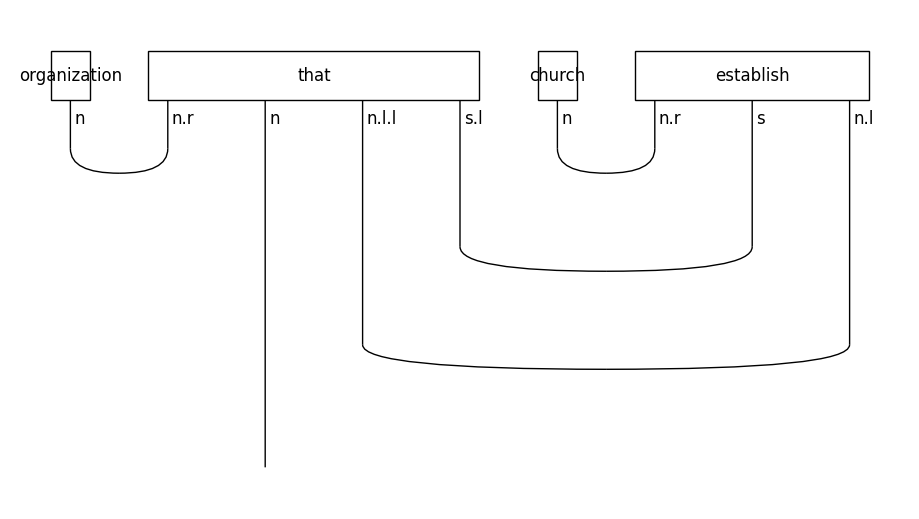

In [10]:
train_diagrams[0].draw(figsize=(9, 5), fontsize=12)

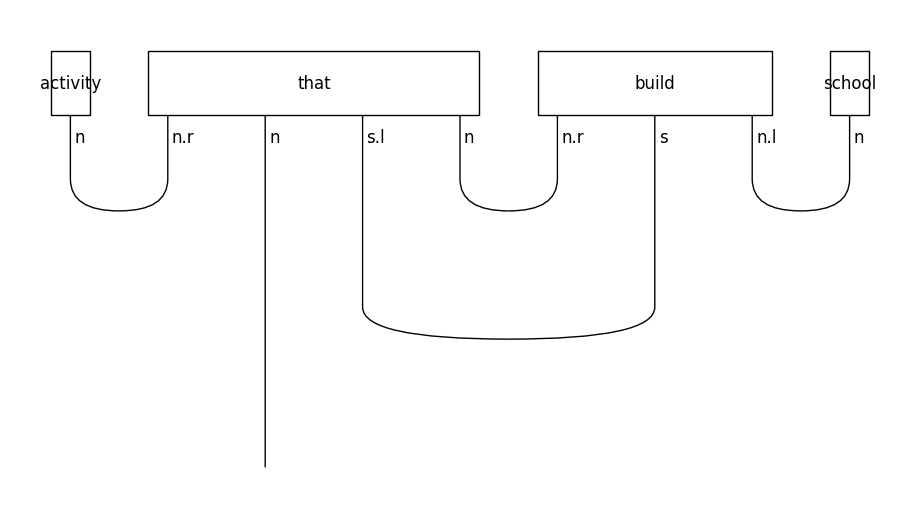

In [11]:
train_diagrams[-1].draw(figsize=(9, 5), fontsize=12)

## Ansatzes... What are they? 😕
An **ansatz** is an educated guess or an initial assumption about the form of a solution to a problem. In the context of quantum computing and lambeq's IQPAnsatz, it means setting up a specific arrangement of quantum gates that we believe will help solve a particular problem.

### Simple Analogy:
Imagine you're trying to solve a puzzle. An ansatz is like making an initial guess about how the pieces might fit together. You start with this guess and then refine it as you go along to find the correct solution.

In quantum computing, an ansatz helps us set up the quantum circuit in a way that we think will work well for processing information. We then test and adjust this setup to get the best results.


## Instantaneous Quantum Polynomial (IQP) ansatz
An IQP ansatz interleaves layers of Hadamard gates with diagonal unitaries. Well... What does _THAT_ mean now?😢

### What is IQPAnsatz?

**IQPAnsatz** is a method used in quantum computing, specifically within the lambeq toolkit, to help process and understand language using quantum circuits. It uses layers of specific quantum gates to process information. IQP circuits are designed to perform specific types of computations very efficiently. They can handle certain problems that are believed to be hard for classical computers to solve.

### How IQPAnsatz Works:

1. **Layers of Gates**: IQPAnsatz arranges quantum gates in layers. Each layer performs a specific operation on the qubits.

2. **Hadamard Gates**: These gates are used to create superpositions, which means they can make qubits be in multiple states at once.

3. **Diagonal Unitaries**: These are special operations that change the state of the qubits in a controlled way.

4. **Combining Layers**: By combining layers of Hadamard gates and diagonal unitaries, IQPAnsatz can process complex information efficiently.

Imagine you have a recipe for making a cake. The recipe tells you to mix ingredients in a specific order and bake them at the right temperature. Similarly, IQPAnsatz is like a recipe for arranging quantum gates to process language data.


Let's walk through a simple example of how a sentence might be processed using the IQPAnsatz.

### Example Sentence:
"Quantum computers are powerful."

### Step-by-Step Processing:

1. **Convert Words to Qubits**:
   - Each word in the sentence is converted into a quantum bit (qubit). So, "Quantum," "computers," "are," and "powerful" each become a qubit.

2. **Initial State Preparation**:
   - The qubits are prepared in an initial state. Think of this as setting up the pieces on a chessboard before the game starts.

3. **Apply Hadamard Gates**:
   - Hadamard gates are applied to the qubits to create superpositions. This means each qubit can now represent multiple states at once, allowing for parallel processing.

4. **Apply Diagonal Unitaries**:
   - Diagonal unitaries are special operations that adjust the state of the qubits based on their initial states. This step helps encode the relationships between the words in the sentence.

5. **Combine Layers**:
   - Multiple layers of Hadamard gates and diagonal unitaries are applied. Each layer refines the information encoded in the qubits, similar to how multiple layers of paint can create a detailed picture.

6. **Measure the Qubits**:
   - Finally, the qubits are measured to get the output. This step collapses the superpositions into a specific state, giving us the processed information.

### Analogy:
Imagine you have a set of light switches (qubits). Initially, all switches are off. You flip some switches (apply Hadamard gates) to create different combinations of on and off states. Then, you adjust the brightness of the lights (apply diagonal unitaries) to represent the relationships between the words. After several adjustments (layers), you take a snapshot (measure the qubits) to see the final arrangement.

For this experiment, we will use an `IQPAnsatz`, where noun wires (``n``) are represented by a one-qubit system, and sentence wires (``s``) are discarded (since we deal with noun phrases).

organization that church establish .


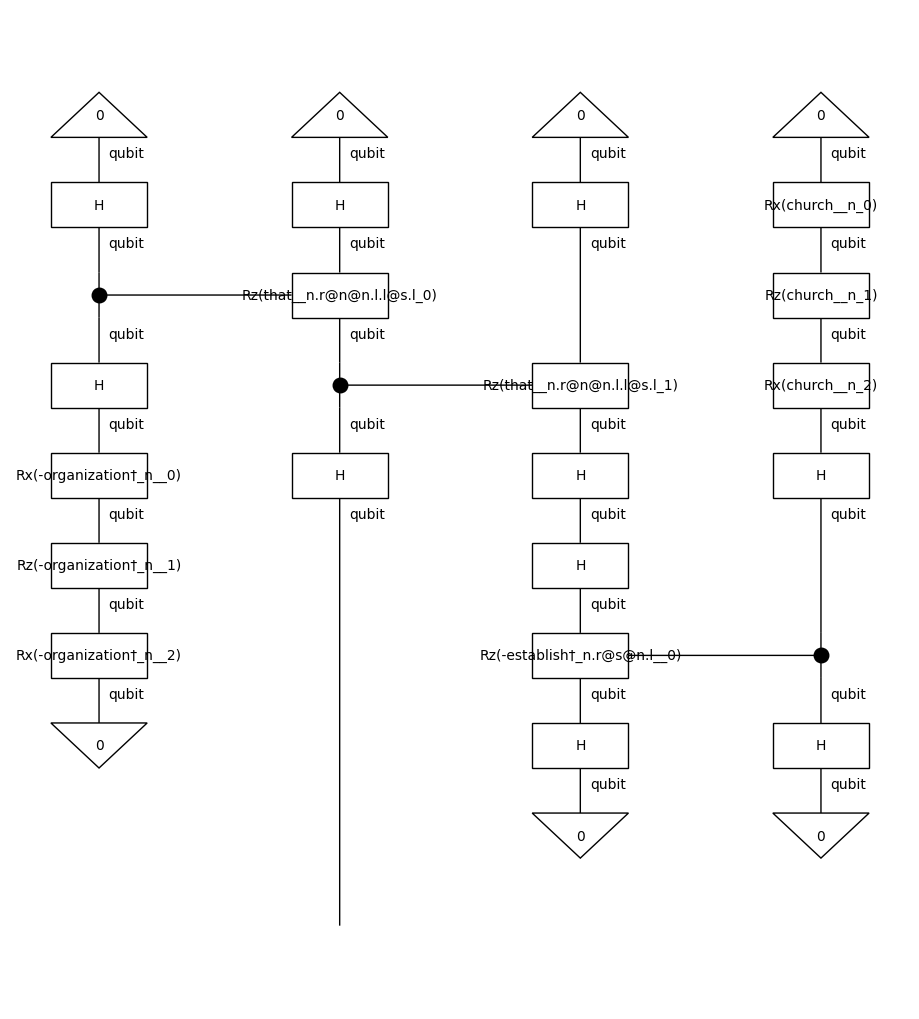

In [12]:
from lambeq import AtomicType, IQPAnsatz, RemoveCupsRewriter

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)
'''
AtomicType.NOUN: 1: 
    This means that each noun will use 1 qubit in the circuit.
AtomicType.SENTENCE: 0: 
    This means that sentences will not use any qubits in the circuit.
n_layers=1: 
    This specifies that the ansatz will use 1 layer of operations.
n_single_qubit_params=3: 
    This indicates that each single qubit will have 3 rotation parameters. 
    This only affects the types mapped to a single qubit by ob_map.
'''
remove_cups = RemoveCupsRewriter()

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]

print(train_data[0])
train_circuits[0].draw(figsize=(9, 10))

### What is RemoveCupsRewriter?

**RemoveCupsRewriter** is a tool used in the lambeq library to simplify diagrams that represent sentences. In the string diagrams, "cups" are specific shapes that represent certain types of connections or relationships between words. They look like U-shaped curves connecting two points.

### What RemoveCupsRewriter Does:

1. **Identify Cups**:
   - The tool looks for these U-shaped connections (cups) in the diagram.

2. **Remove Cups**:
   - It removes these cups and adjusts the diagram accordingly. This helps simplify the overall structure.

3. **Simplify the Diagram**:
   - By removing unnecessary cups, the diagram becomes easier to understand and work with. This can make further processing and analysis more efficient.


Imagine you have a tangled set of strings representing a sentence. The cups are like knots in the strings. The RemoveCupsRewriter is like a tool that untangles these knots, making the strings (the diagram) smoother and easier to follow.

By removing unnecessary connections, the diagram becomes less cluttered and easier to read and interpret. Each cup represents an operation that needs to be performed. Removing cups reduces the number of operations, making the computation faster and more efficient.

Note that we remove the `cups` before parameterising the diagrams. By doing so, we reduce the number of `post-selections`, which makes the model computationally more efficient. The effect of cups removal on a `string diagram` is demonstrated below:


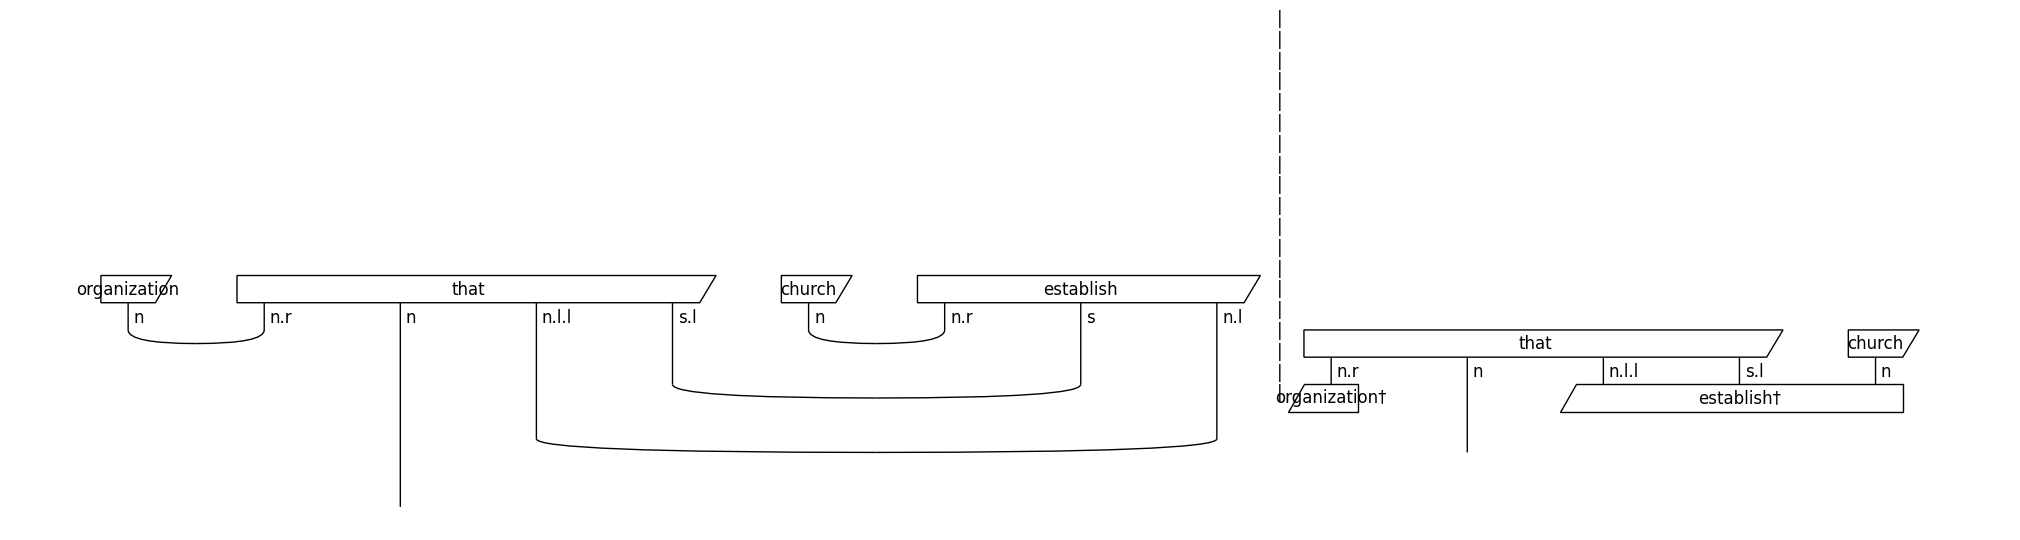

In [13]:
from lambeq.backend import draw_equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

draw_equation(original_diagram, removed_cups_diagram, symbol='|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|\n|', \
              figsize=(20, 5), asymmetry=0.3, fontsize=12)

## Converting circuit diagrams into Pennylane circuits
Lambeq provides integrations with a wide variety of QuantumML backends like Pennylane, Qiskit, Tket, etc.
We shall choose Pennylane here. The `from_diagrams` method of the `PennylaneModel` class directly converts the given circuit into a pennylane model.

In [14]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + val_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
model = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
model.initialise_weights() #Random initialization

## Create dataset
To facilitate data shuffling and batching, lambeq provides a native Dataset class. Shuffling is enabled by default, and if not specified, the batch size is set to the length of the dataset.

In [15]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

## Define loss and evaluation metric
When using PytorchTrainer we first define our evaluation metrics and loss function, which in this case will be the accuracy and the binary cross-entropy loss, respectively.

In [16]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)

In [17]:
from lambeq import PytorchTrainer

if torch.cuda.is_available():
    trainer = PytorchTrainer(
        model=model,
        loss_function=loss,
        optimizer=torch.optim.Adam,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions={'acc': acc},
        evaluate_on_train=True,
        use_tensorboard=False,
        verbose='text',
        seed=SEED,
        device=torch.cuda.current_device())
else:
    trainer = PytorchTrainer(
        model=model,
        loss_function=loss,
        optimizer=torch.optim.Adam,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions={'acc': acc},
        evaluate_on_train=True,
        use_tensorboard=False,
        verbose='text',
        seed=SEED)

In [18]:
trainer.fit(train_dataset, val_dataset,
            early_stopping_criterion='acc',
            early_stopping_interval=5,
            minimize_criterion=False)

Epoch 1:    train/loss: 0.5475   valid/loss: 0.5963   train/time: 3.40s   valid/time: 1.15s   train/acc: 0.8429   valid/acc: 0.8387
Epoch 2:    train/loss: 0.5316   valid/loss: 0.5977   train/time: 2.64s   valid/time: 0.73s   train/acc: 0.9143   valid/acc: 0.8387
Epoch 3:    train/loss: 0.5960   valid/loss: 0.5837   train/time: 2.78s   valid/time: 0.76s   train/acc: 0.9429   valid/acc: 0.8387
Epoch 4:    train/loss: 0.5462   valid/loss: 0.5593   train/time: 2.64s   valid/time: 0.81s   train/acc: 0.9571   valid/acc: 0.9032
Epoch 5:    train/loss: 0.5069   valid/loss: 0.5700   train/time: 2.67s   valid/time: 1.03s   train/acc: 0.9714   valid/acc: 0.8710
Epoch 6:    train/loss: 0.5534   valid/loss: 0.5525   train/time: 2.79s   valid/time: 0.92s   train/acc: 0.9857   valid/acc: 0.9355
Epoch 7:    train/loss: 0.5067   valid/loss: 0.5731   train/time: 2.71s   valid/time: 0.85s   train/acc: 0.9857   valid/acc: 0.8387
Epoch 8:    train/loss: 0.5582   valid/loss: 0.5519   train/time: 2.96s   va

Final validation accuracy: 0.9354838709677419


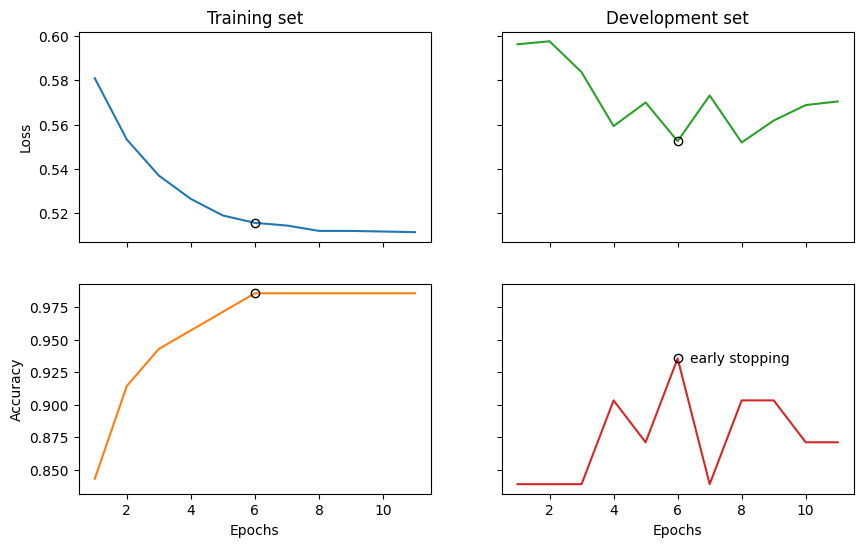

In [19]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, len(trainer.train_epoch_costs)+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# mark best model as circle
best_epoch = np.argmax(trainer.val_eval_results['acc'])
ax_tl.plot(best_epoch + 1, trainer.train_epoch_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_tr.plot(best_epoch + 1, trainer.val_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_bl.plot(best_epoch + 1, trainer.train_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')
ax_br.plot(best_epoch + 1, trainer.val_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')

ax_br.text(best_epoch + 1.4, trainer.val_eval_results['acc'][best_epoch], 'early stopping', va='center')

# print test accuracy
model.load(trainer.log_dir + '/best_model.lt')
pred = model(val_circuits)
labels = torch.tensor(val_labels)
print('Final validation accuracy: {}'.format(acc(pred, labels)))